## Importing Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
!pip install nltk

In [5]:
!pip install spacy

In [6]:
import nltk
import spacy
import re

In [7]:
!pip install lightgbm

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier  # Requires: pip install xgboost
from lightgbm import LGBMClassifier 

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Bidirectional, LSTM, Conv1D
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [13]:
import seaborn as sns

## Exploratory Data Analysis

In [15]:
df = pd.read_csv('Data.csv')

In [16]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [18]:
df.isnull().sum()

Sentence     0
Sentiment    0
dtype: int64

In [19]:
df.duplicated().sum()

np.int64(6)

In [20]:
df.drop_duplicates(inplace=True)

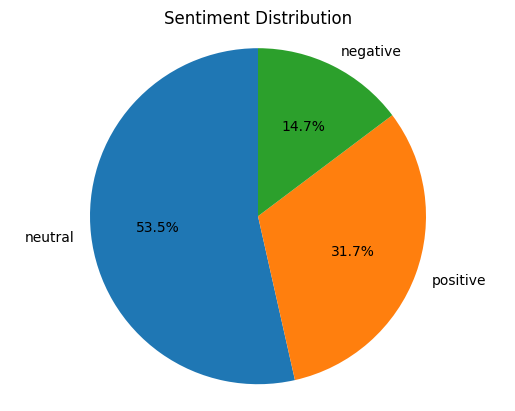

In [21]:
sentiment_counts = df['Sentiment'].value_counts()

# Plot the pie chart
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution')
plt.axis('equal')
plt.show()

## Text Preprocessing

In [23]:
# Download resources (only once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mahit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mahit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mahit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [25]:
def preprocess(text):
    text = text.lower()                              # Lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@w+|\#','', text)               # Remove @, #
    text = re.sub(r'[^a-z\s]', '', text)             # Remove punctuation/numbers
    tokens = nltk.word_tokenize(text)                # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatize & remove stopwords
    return ' '.join(tokens)

In [26]:
df['Cleaned'] = df['Sentence'].astype(str).apply(preprocess)

In [27]:
df.head()

,Sentence,Sentiment,Cleaned
0,The GeoSolutions technology will leverage Bene...,positive,geosolutions technology leverage benefon gps s...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,esi low bk real possibility
2,"For the last quarter of 2010 , Componenta 's n...",positive,last quarter componenta net sale doubled eurm ...
3,According to the Finnish-Russian Chamber of Co...,neutral,according finnishrussian chamber commerce majo...
4,The Swedish buyout firm has sold its remaining...,neutral,swedish buyout firm sold remaining percent sta...


In [28]:
# Drop the original 'Sentence' column
df.drop('Sentence', axis=1, inplace=True)

# Rename 'Cleaned' column to 'text'
df.rename(columns={'Cleaned': 'text'}, inplace=True)

In [29]:
df.head()

,Sentiment,text
0,positive,geosolutions technology leverage benefon gps s...
1,negative,esi low bk real possibility
2,positive,last quarter componenta net sale doubled eurm ...
3,neutral,according finnishrussian chamber commerce majo...
4,neutral,swedish buyout firm sold remaining percent sta...


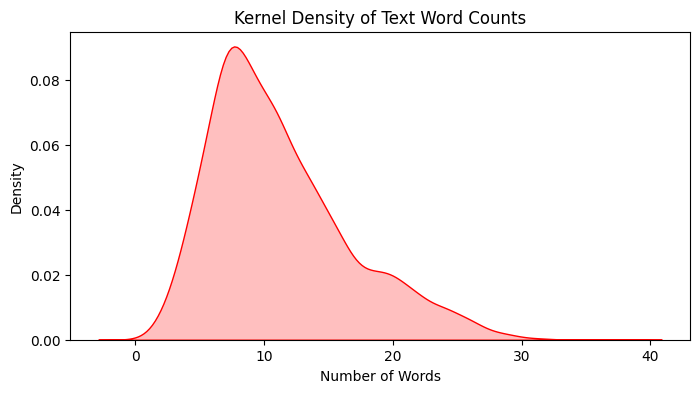

In [30]:
# Compute word count for each row
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Now plot the KDE
plt.figure(figsize=(8,4))
sns.kdeplot(df['word_count'], shade=True, color="r").set_title('Kernel Density of Text Word Counts')
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()

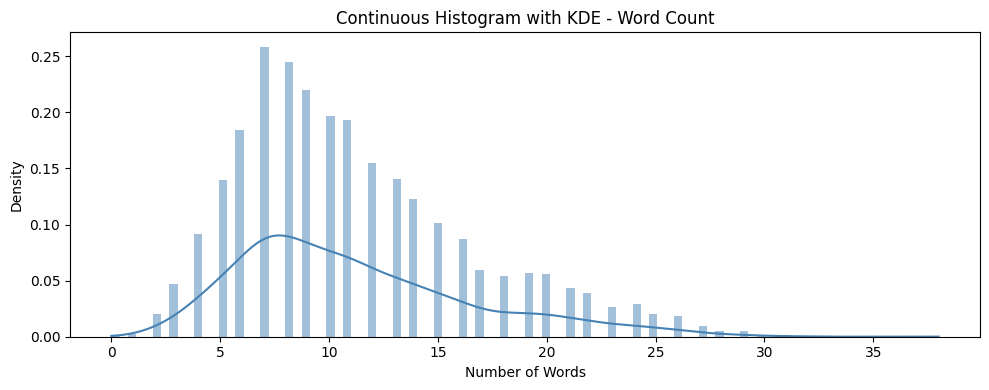

In [31]:
# Make sure word_count is computed
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Plot with 100 bins and KDE
plt.figure(figsize=(10, 4))
sns.histplot(df['word_count'], bins=100, kde=True, stat="density", color="steelblue", edgecolor=None)
plt.title("Continuous Histogram with KDE - Word Count")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

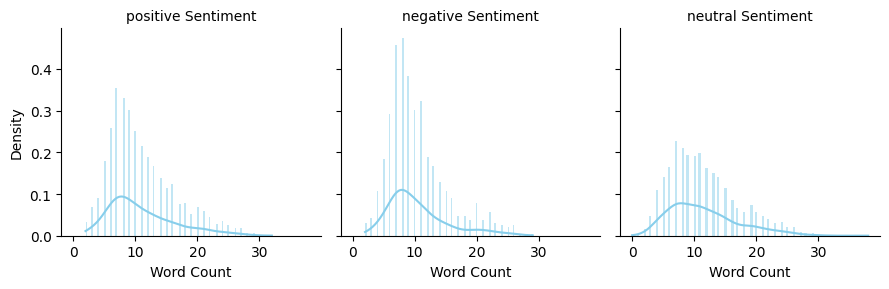

In [32]:
# Make sure word_count is present
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Plot using FacetGrid
g = sns.FacetGrid(df, col="Sentiment", col_wrap=3, height=3, sharex=True, sharey=True)
g.map(sns.histplot, 'word_count', bins=100, kde=True, stat='density', color='skyblue', edgecolor=None)

# Tidy titles and layout
g.set_titles(col_template="{col_name} Sentiment")
g.set_axis_labels("Word Count", "Density")
plt.tight_layout()
plt.show()

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['text'])
y = df['Sentiment']  # or df['label'] if encoded

In [34]:
print(X[:5].toarray())  # Convert sparse matrix to dense

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [35]:
print(X.shape)
# Example output: (1000, 5000) → 1000 texts, 5000 features

(5836, 5000)


In [36]:
print(vectorizer.get_feature_names_out()[:20])  # First 20 features

['aapl' 'ab' 'ab inbev' 'ab sto' 'abb' 'abc' 'able' 'abp' 'abp hel'
 'abroad' 'ac' 'ac drive' 'access' 'accessory' 'accordance' 'according'
 'according ceo' 'according company' 'according finnish'
 'according interim']


In [37]:
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
X_df.head()

,aapl,ab,ab inbev,ab sto,abb,abc,able,abp,abp hel,abroad,...,yet,yhoo,yield,yit,yit corporation,yit oyj,york,zinc,znga,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Splitting

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

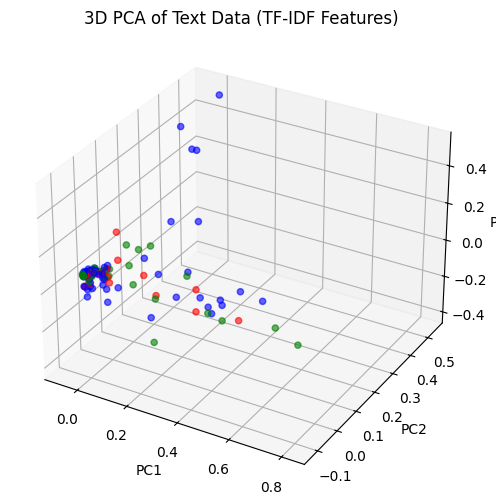

In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Reduce X_train to 3 dimensions using PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train.toarray())

# Plot only the first 200 points (for clarity)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

# Convert labels to colors
colors = {'positive': 'green', 'negative': 'red', 'neutral': 'blue'}
label_colors = [colors[label] for label in y_train[:200]]

# 3D scatter plot
ax.scatter(X_pca[:200, 0], X_pca[:200, 1], X_pca[:200, 2], c=label_colors, alpha=0.6)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('3D PCA of Text Data (TF-IDF Features)')
plt.show()

In [41]:
from sklearn.preprocessing import LabelEncoder

# Encode labels once
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

## Model Training


=== RandomForest ===
Accuracy: 0.651541095890411
              precision    recall  f1-score   support

    negative       0.21      0.23      0.22       159
     neutral       0.72      0.76      0.74       666
    positive       0.75      0.63      0.68       343

    accuracy                           0.65      1168
   macro avg       0.56      0.54      0.55      1168
weighted avg       0.66      0.65      0.65      1168



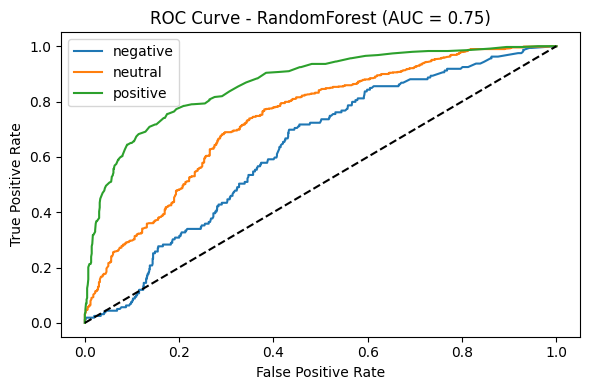

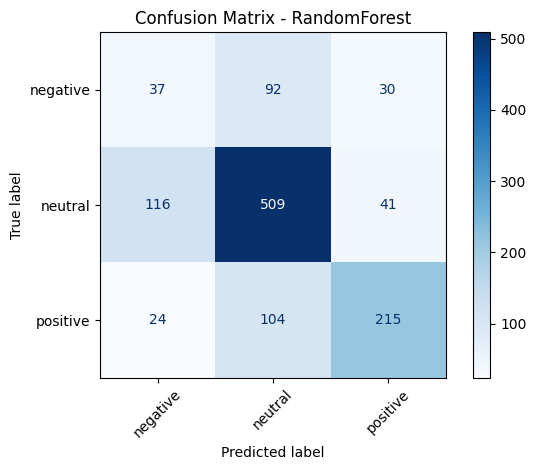


=== GaussianNB ===
Accuracy: 0.5565068493150684
              precision    recall  f1-score   support

    negative       0.23      0.37      0.28       159
     neutral       0.73      0.58      0.65       666
    positive       0.54      0.59      0.57       343

    accuracy                           0.56      1168
   macro avg       0.50      0.52      0.50      1168
weighted avg       0.61      0.56      0.57      1168



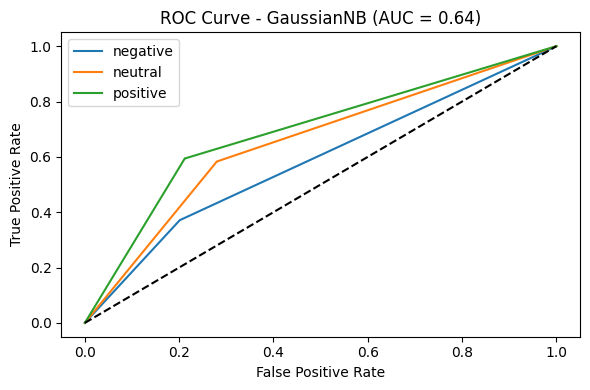

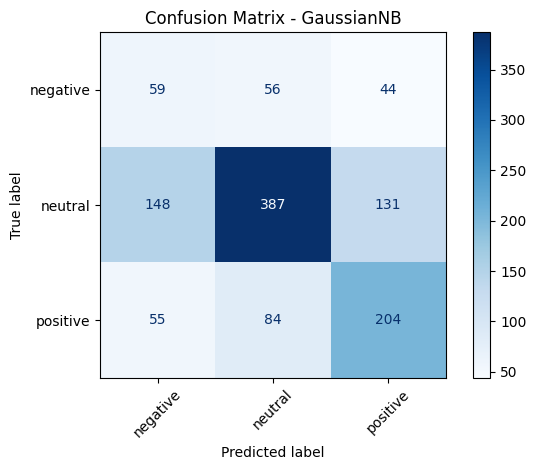


=== MultinomialNB ===
Accuracy: 0.7046232876712328
              precision    recall  f1-score   support

    negative       0.32      0.07      0.11       159
     neutral       0.73      0.90      0.81       666
    positive       0.68      0.62      0.65       343

    accuracy                           0.70      1168
   macro avg       0.58      0.53      0.52      1168
weighted avg       0.66      0.70      0.67      1168



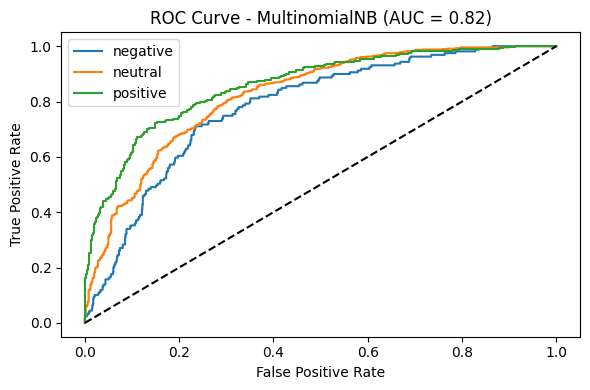

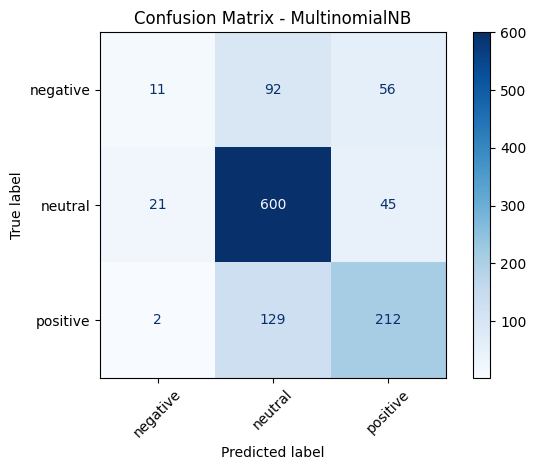


=== LogisticReg ===
Accuracy: 0.7063356164383562
              precision    recall  f1-score   support

    negative       0.37      0.16      0.23       159
     neutral       0.73      0.88      0.80       666
    positive       0.74      0.62      0.67       343

    accuracy                           0.71      1168
   macro avg       0.61      0.55      0.56      1168
weighted avg       0.68      0.71      0.68      1168



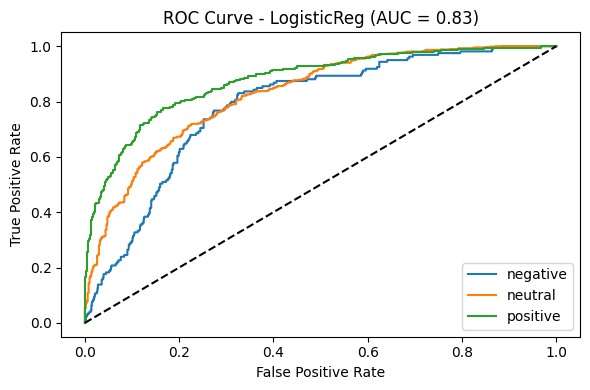

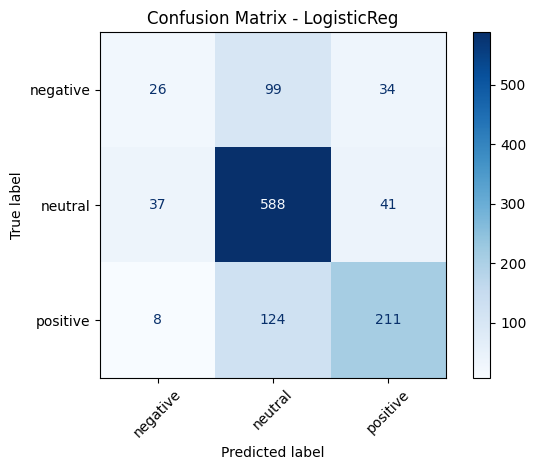


=== LinearSVC ===
Accuracy: 0.6712328767123288
              precision    recall  f1-score   support

    negative       0.24      0.23      0.23       159
     neutral       0.74      0.77      0.75       666
    positive       0.72      0.69      0.70       343

    accuracy                           0.67      1168
   macro avg       0.57      0.56      0.56      1168
weighted avg       0.67      0.67      0.67      1168



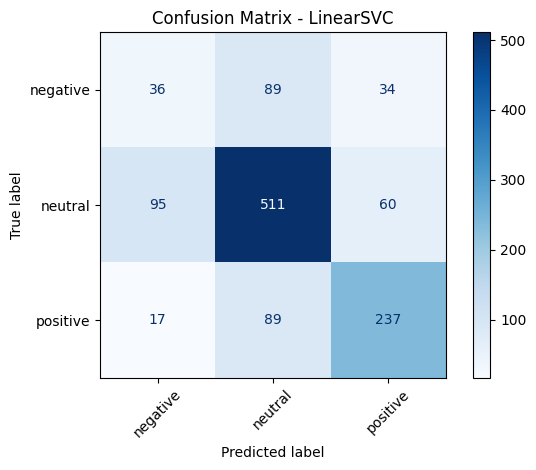


=== GradientBoost ===
Accuracy: 0.6678082191780822
              precision    recall  f1-score   support

    negative       0.36      0.13      0.19       159
     neutral       0.67      0.91      0.77       666
    positive       0.75      0.45      0.56       343

    accuracy                           0.67      1168
   macro avg       0.59      0.49      0.51      1168
weighted avg       0.65      0.67      0.63      1168



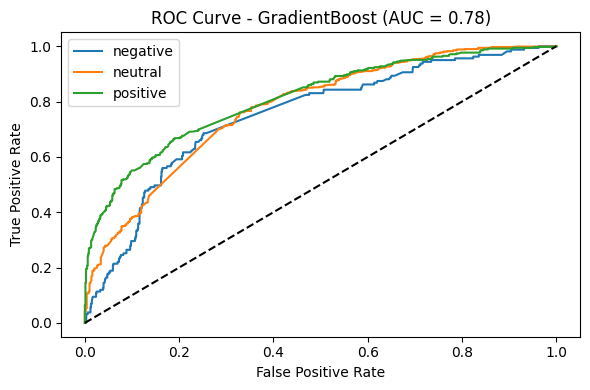

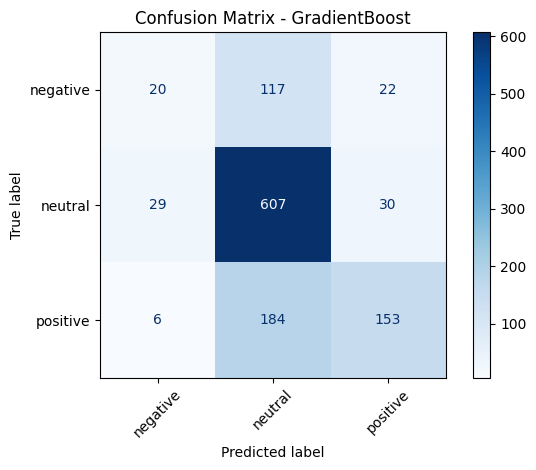


=== AdaBoost ===
Accuracy: 0.5916095890410958
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       159
     neutral       0.58      0.99      0.74       666
    positive       0.81      0.08      0.15       343

    accuracy                           0.59      1168
   macro avg       0.46      0.36      0.30      1168
weighted avg       0.57      0.59      0.46      1168



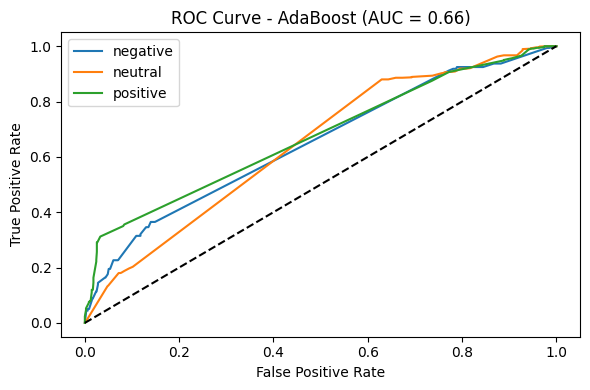

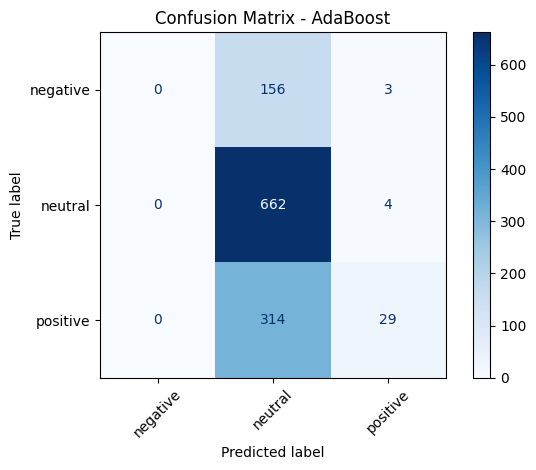


=== ComplementNB ===
Accuracy: 0.690068493150685
              precision    recall  f1-score   support

    negative       0.35      0.45      0.39       159
     neutral       0.81      0.74      0.77       666
    positive       0.68      0.71      0.69       343

    accuracy                           0.69      1168
   macro avg       0.61      0.63      0.62      1168
weighted avg       0.71      0.69      0.70      1168



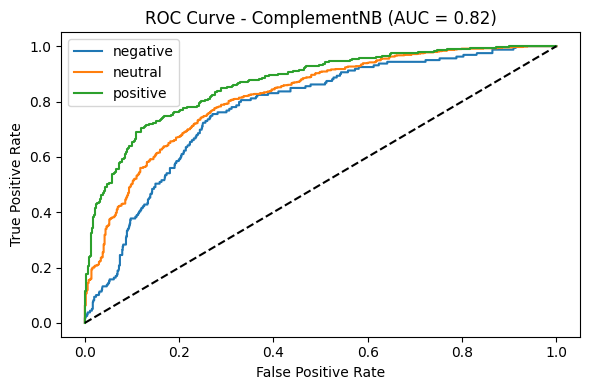

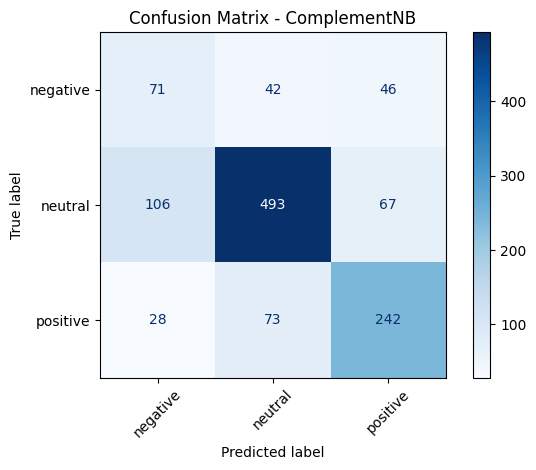


=== XGBoost ===
Accuracy: 0.6643835616438356
              precision    recall  f1-score   support

    negative       0.25      0.15      0.19       159
     neutral       0.69      0.84      0.76       666
    positive       0.72      0.56      0.63       343

    accuracy                           0.66      1168
   macro avg       0.56      0.52      0.53      1168
weighted avg       0.64      0.66      0.64      1168



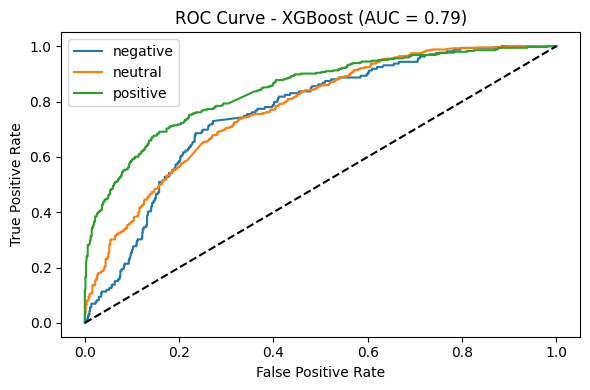

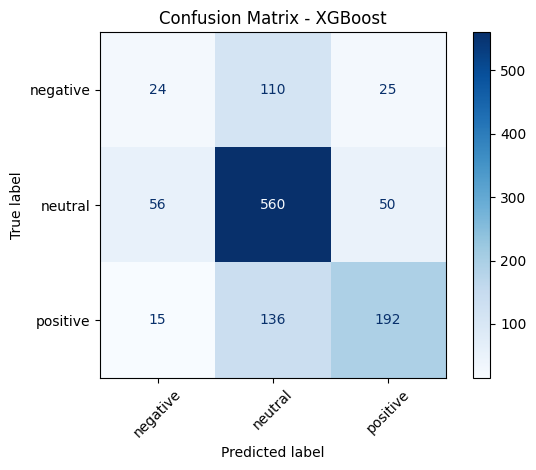


=== LightGBM ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10548
[LightGBM] [Info] Number of data points in the train set: 4668, number of used features: 556
[LightGBM] [Info] Start training from score -1.895978
[LightGBM] [Info] Start training from score -0.641383
[LightGBM] [Info] Start training from score -1.129284
Accuracy: 0.6472602739726028
              precision    recall  f1-score   support

    negative       0.23      0.19      0.21       159
     neutral       0.70      0.78      0.74       666
    positive       0.69      0.59      0.64       343

    accuracy                           0.65      1168
   macro avg       0.54      0.52      0.53      1168
weighted avg       0.63      0.65      0.64      1168



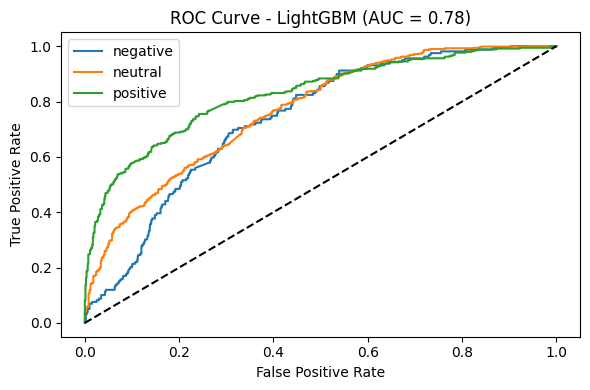

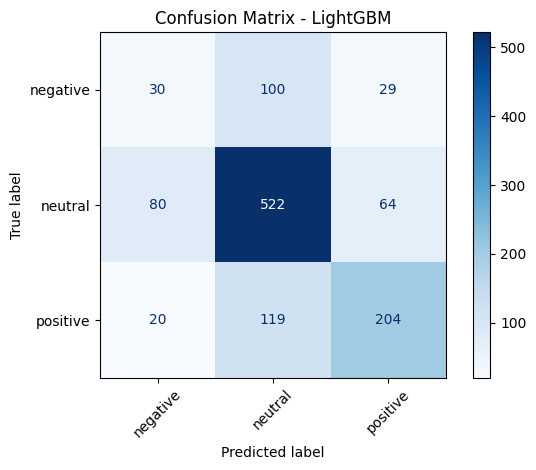

In [43]:
from sklearn.metrics import (classification_report, accuracy_score, 
                             roc_auc_score, roc_curve, confusion_matrix, 
                             ConfusionMatrixDisplay)
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

models = {
    "RandomForest"   : RandomForestClassifier(n_estimators=100, random_state=42),
    "GaussianNB"     : GaussianNB(),
    "MultinomialNB"  : MultinomialNB(),     
    "LogisticReg"    : LogisticRegression(max_iter=1000),
    "LinearSVC"      : LinearSVC(max_iter=10000),
    "GradientBoost"  : GradientBoostingClassifier(random_state=42),
    "AdaBoost"       : AdaBoostClassifier(random_state=42),
    "ComplementNB"   : ComplementNB(),
    "XGBoost"        : XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM"       : LGBMClassifier(random_state=42),
}


# Label encoding
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Binarize labels for ROC AUC
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test_enc)

# Track performance
metrics_summary = {}

# Dense requirement list
_dense_needed = {"GaussianNB", "MultinomialNB", "MLP"}

for name, clf in models.items():
    print(f"\n=== {name} ===")
    
    # Use dense if required
    if name in _dense_needed:
        X_tr = X_train.toarray()
        X_te = X_test.toarray()
    else:
        X_tr, X_te = X_train, X_test

    # Train & Predict
    clf.fit(X_tr, y_train_enc)
    preds_enc = clf.predict(X_te)
    preds = le.inverse_transform(preds_enc)  # For human-readable output

    # Accuracy
    acc = accuracy_score(y_test, preds)
    print("Accuracy:", acc)

    # Classification Report
    print(classification_report(y_test, preds, zero_division=0))

    # Save metrics
    report = classification_report(y_test, preds, output_dict=True, zero_division=0)
    metrics_summary[name] = {
        'accuracy': acc,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score']
    }

    # ROC AUC Curve
    if hasattr(clf, "predict_proba"):
        probas = clf.predict_proba(X_te)
        try:
            auc = roc_auc_score(y_test_bin, probas, multi_class='ovr')
            fpr, tpr = {}, {}
            for i in range(y_test_bin.shape[1]):
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probas[:, i])

            plt.figure(figsize=(6, 4))
            for i, label in enumerate(le.classes_):
                plt.plot(fpr[i], tpr[i], label=f"{label}")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.title(f"ROC Curve - {name} (AUC = {auc:.2f})")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend()
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"ROC AUC failed for {name}: {e}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, preds, labels=le.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

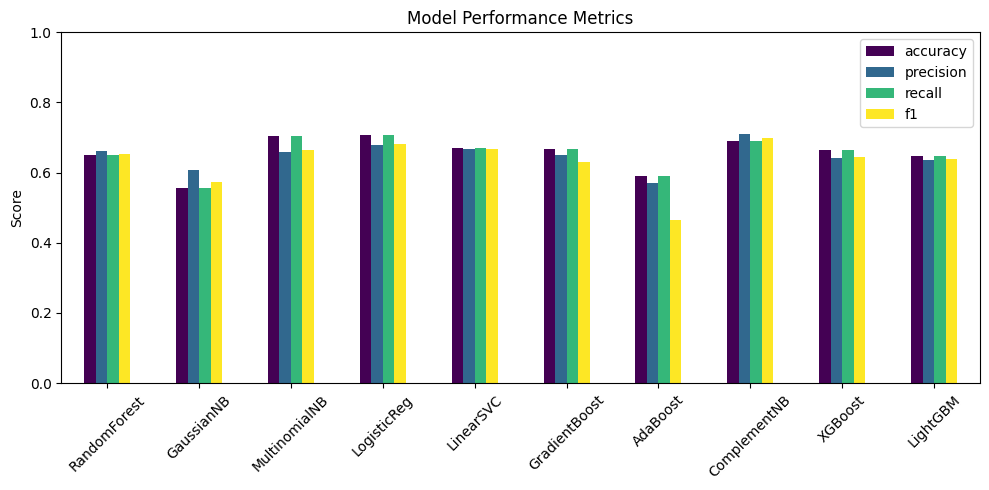

In [44]:
# Barplot summary of metrics
metrics_df = pd.DataFrame(metrics_summary).T
metrics_df.plot(kind='bar', figsize=(10, 5), colormap='viridis')
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [45]:
# Create and display metrics table, sorted by accuracy
metrics_df = pd.DataFrame(metrics_summary).T
metrics_df = metrics_df.round(4)
metrics_df = metrics_df.sort_values(by='accuracy', ascending=False)

print("\n=== Model Performance Summary (Sorted by Accuracy) ===")
print(metrics_df)


=== Model Performance Summary (Sorted by Accuracy) ===
               accuracy  precision  recall      f1
LogisticReg      0.7063     0.6799  0.7063  0.6818
MultinomialNB    0.7046     0.6597  0.7046  0.6655
ComplementNB     0.6901     0.7097  0.6901  0.6980
LinearSVC        0.6712     0.6663  0.6712  0.6685
GradientBoost    0.6678     0.6499  0.6678  0.6292
XGBoost          0.6644     0.6417  0.6644  0.6444
RandomForest     0.6515     0.6609  0.6515  0.6541
LightGBM         0.6473     0.6348  0.6473  0.6386
AdaBoost         0.5916     0.5700  0.5916  0.4648
GaussianNB       0.5565     0.6075  0.5565  0.5740


## Using LSTM and CNN

In [47]:
def build_sentiment_model(max_len, vocab_size, embed_size, embedding_matrix, num_classes=3, lr=1e-3, dropout_rate=0.3):
    inp = Input(shape=(max_len,))
    x = Embedding(input_dim=vocab_size, output_dim=embed_size, weights=[embedding_matrix],
                  input_length=max_len, trainable=False)(inp)
    x = SpatialDropout1D(0.2)(x)

    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Conv1D(64, kernel_size=3, activation='relu')(x)

    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])

    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
    return model

In [48]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])  # assuming df['text'] contains your preprocessed text
# Build the model first
max_len = max(df['text'].apply(lambda x: len(x.split())))
vocab_size = len(tokenizer.word_index) + 1
embed_size = 100  # or 300 depending on your embeddings
embedding_matrix = np.random.randn(vocab_size, embed_size)

model = build_sentiment_model(
    max_len=max_len,
    vocab_size=vocab_size,
    embed_size=embed_size,
    embedding_matrix=embedding_matrix,
    num_classes=3  # adjust based on your sentiment labels
)

In [49]:
from tensorflow.keras.utils import to_categorical


# Tokenization
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
X_seq = tokenizer.texts_to_sequences(df['text'])

# Padding
max_len = max(len(seq) for seq in X_seq)
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

# Label Encoding + One-hot
le = LabelEncoder()
y_enc = le.fit_transform(df['Sentiment'])  # text labels → integers
y_ohe = to_categorical(y_enc, num_classes=3)  # integers → one-hot

# Train-test split
X_train_pad, X_test_pad, y_train_ohe, y_test_ohe = train_test_split(
    X_pad, y_ohe, test_size=0.2, random_state=42)


In [62]:
history = model.fit(
    X_train_pad, y_train_ohe,
    batch_size=128,
    epochs=10,
    validation_split=0.1,
)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.8559 - loss: 0.3340 - val_accuracy: 0.5803 - val_loss: 1.2964
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.8766 - loss: 0.2904 - val_accuracy: 0.5867 - val_loss: 1.4903
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.8653 - loss: 0.2914 - val_accuracy: 0.5974 - val_loss: 1.4649
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.8631 - loss: 0.2871 - val_accuracy: 0.5696 - val_loss: 1.4066
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.8696 - loss: 0.2782 - val_accuracy: 0.5782 - val_loss: 1.6128
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.8769 - loss: 0.2738 - val_accuracy: 0.5846 - val_loss: 1.4551
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.8843 - loss: 0.2483 - val_accuracy: 0.5889 - val_loss: 1.3857
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.8848 - loss: 0.2469 - val_accuracy: 0.5

In [63]:
loss, acc = model.evaluate(X_test_pad, y_test_ohe, verbose=0)
print(f"Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")

Test Accuracy: 0.6404, Test Loss: 1.3532


## Replacing LSTM with GRU (Gated Recurrent Units) [but bidirectional]

In [292]:
def build_sentiment_model(max_len, vocab_size, embed_size, embedding_matrix, num_classes=3, lr=1e-3, dropout_rate=0.3):
    inp = Input(shape=(max_len,))
    x = Embedding(input_dim=vocab_size, output_dim=embed_size, weights=[embedding_matrix],
                  input_length=max_len, trainable=False)(inp)
    x = SpatialDropout1D(0.2)(x)

    x = Bidirectional(GRU(100, return_sequences=True))(x)
    x = Conv1D(64, kernel_size=3, activation='relu')(x)

    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])

    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
    return model

In [294]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])  # assuming df['text'] contains your preprocessed text
# Build the model first
max_len = max(df['text'].apply(lambda x: len(x.split())))
vocab_size = len(tokenizer.word_index) + 1
embed_size = 100  # or 300 depending on your embeddings
embedding_matrix = np.random.randn(vocab_size, embed_size)

model = build_sentiment_model(
    max_len=max_len,
    vocab_size=vocab_size,
    embed_size=embed_size,
    embedding_matrix=embedding_matrix,
    num_classes=3  # adjust based on your sentiment labels
)

In [296]:
from tensorflow.keras.utils import to_categorical


# Tokenization
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
X_seq = tokenizer.texts_to_sequences(df['text'])

# Padding
max_len = max(len(seq) for seq in X_seq)
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

# Label Encoding + One-hot
le = LabelEncoder()
y_enc = le.fit_transform(df['Sentiment'])  # text labels → integers
y_ohe = to_categorical(y_enc, num_classes=3)  # integers → one-hot

# Train-test split
X_train_pad, X_test_pad, y_train_ohe, y_test_ohe = train_test_split(
    X_pad, y_ohe, test_size=0.2, random_state=42)


In [306]:
history = model.fit(
    X_train_pad, y_train_ohe,
    batch_size=128,
    epochs=20,
    validation_split=0.1,
)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.8926 - loss: 0.2083 - val_accuracy: 0.5953 - val_loss: 1.5040
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.8916 - loss: 0.2310 - val_accuracy: 0.5782 - val_loss: 1.9152
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9008 - loss: 0.2185 - val_accuracy: 0.5653 - val_loss: 1.3452
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9050 - loss: 0.1976 - val_accuracy: 0.5653 - val_loss: 1.5733
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9089 - loss: 0.1863 - val_accuracy: 0.5760 - val_loss: 1.7225
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9075 - loss: 0.2072 - val_accuracy: 0.5824 - val_loss: 1.8392
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.8955 - loss: 0.1975 - val_accuracy: 0.5867 - val_loss: 1.5808
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.8945 - loss: 0.2066 - val_accuracy: 0.

In [307]:
loss, acc = model.evaluate(X_test_pad, y_test_ohe, verbose=0)
print(f"Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")

Test Accuracy: 0.6284, Test Loss: 1.7788


## ATTENTION MECHANISM

In [187]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import tensorflow as tf

class AttentionWithContext(Layer):
    def __init__(self, return_attention=False, **kwargs):
        self.return_attention = return_attention
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='W', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform', trainable=True)
        self.u = self.add_weight(name='u', shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform', trainable=True)
        super().build(input_shape)

    def call(self, x):
        uit = K.tanh(K.dot(x, self.W))
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.softmax(ait)

        weighted_input = x * K.expand_dims(ait)
        output = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [output, ait]
        return output


## -WITH BIDIRECTIONAL LSTM

In [189]:
def build_model_with_attention_output(max_len, vocab_size, embed_size, embedding_matrix, num_classes=3):
    inp = Input(shape=(max_len,))
    x = Embedding(input_dim=vocab_size, output_dim=embed_size,
                  weights=[embedding_matrix], input_length=max_len, trainable=False)(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x, attention_weights = AttentionWithContext(return_attention=True)(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # For attention visualization
    att_model = Model(inputs=inp, outputs=attention_weights)

    return model, att_model


In [191]:
def show_attention(sentence, tokenizer, model, att_model, max_len):
    seq = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    att_weights = att_model.predict(padded)[0]  # shape: (max_len,)

    tokens = tokenizer.sequences_to_texts(seq)[0].split()
    att_weights = att_weights[:len(tokens)]

    plt.figure(figsize=(10, 1))
    plt.bar(range(len(tokens)), att_weights)
    plt.xticks(range(len(tokens)), tokens, rotation=45)
    plt.title("Attention over words")
    plt.show()


In [195]:
model, att_model = build_model_with_attention_output(
    max_len=max_len,
    vocab_size=vocab_size,
    embed_size=embed_size,
    embedding_matrix=embedding_matrix,
    num_classes=3
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step


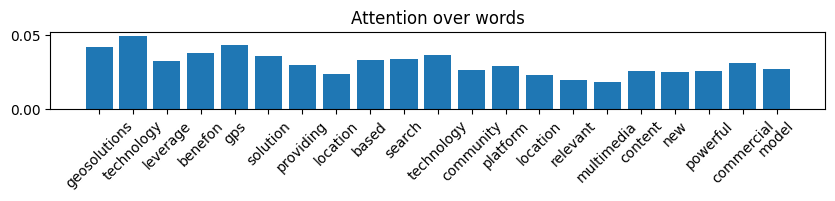

In [197]:
show_attention(df["text"][0], tokenizer, model, att_model, max_len)

In [219]:
from IPython.display import display, HTML

def show_colored_attention(sentence, tokenizer, att_model, max_len):
    # Tokenize and pad
    seq = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    att_weights = att_model.predict(padded)[0]

    # Get words (drop padding)
    tokens = tokenizer.sequences_to_texts(seq)[0].split()
    att_weights = att_weights[:len(tokens)]

    # Normalize attention weights to [0, 1]
    att_weights = (att_weights - att_weights.min()) / (att_weights.max() - att_weights.min() + 1e-8)

    # Generate HTML with attention-weighted background colors
    html_text = ''
    for word, weight in zip(tokens, att_weights):
        color = f'rgba(255, 0, 0, {weight:.2f})'  # red intensity
        html_text += f'<span style="background-color:{color}; padding:2px; margin:2px;">{word}</span> '

    display(HTML(html_text))


In [221]:
show_colored_attention(df["text"][0], tokenizer, att_model, max_len)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


In [225]:
def show_colored_attention_all_probs(sentence, tokenizer, model, att_model, max_len, label_encoder=None):
    import pandas as pd
    from IPython.display import display, HTML

    # Tokenize
    seq = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    tokens = tokenizer.sequences_to_texts(seq)[0].split()

    # Predict
    probs = model.predict(padded, verbose=0)[0]
    pred_class = np.argmax(probs)
    pred_prob = probs[pred_class]
    class_names = label_encoder.inverse_transform(np.arange(len(probs))) if label_encoder else [str(i) for i in range(len(probs))]

    # Attention
    att_weights = att_model.predict(padded, verbose=0)[0][:len(tokens)]
    att_weights = (att_weights - att_weights.min()) / (att_weights.max() - att_weights.min() + 1e-8)

    # Prediction summary
    pred_label = class_names[pred_class]
    summary_html = f"<div><b>Prediction:</b> {pred_label} ({pred_prob:.2f})</div>"

    # Color-coded tokens
    token_html = ""
    for word, weight in zip(tokens, att_weights):
        hue = int((1 - weight) * 120)
        color = f'rgba(255, 0, 0, {weight:.2f})'
        token_html += f'<span style="background-color:{color}; padding:3px; margin:2px; border-radius:4px;">{word}</span> '

    # Class probability table
    prob_df = pd.DataFrame({'Class': class_names, 'Probability': [f"{p:.2f}" for p in probs]})
    table_html = prob_df.to_html(index=False)

    display(HTML(summary_html + "<br>" + token_html + "<br><br>" + table_html))


In [227]:
def visualize_batch_attention(texts, tokenizer, model, att_model, max_len, label_encoder=None, n=5):
    for i in range(min(n, len(texts))):
        print(f"\n Sample {i+1}:")
        show_colored_attention_all_probs(texts[i], tokenizer, model, att_model, max_len, label_encoder)


In [229]:

test_indices = X_test_pad[:5].shape[0]
test_texts = df['text'].iloc[:test_indices].tolist()

visualize_batch_attention(test_texts, tokenizer, model, att_model, max_len, label_encoder=le, n=5)


 Sample 1:


Class,Probability
negative,0.26
neutral,0.40
positive,0.34



 Sample 2:


Class,Probability
negative,0.19
neutral,0.46
positive,0.35



 Sample 3:


Class,Probability
negative,0.23
neutral,0.44
positive,0.32



 Sample 4:


Class,Probability
negative,0.21
neutral,0.44
positive,0.35



 Sample 5:


Class,Probability
negative,0.21
neutral,0.42
positive,0.36


In [231]:
X_train_pad, X_test_pad, y_train_ohe, y_test_ohe, text_train, text_test = train_test_split(
    X_pad, y_ohe, df['text'], test_size=0.2, random_state=42)

In [234]:
def visualize_misclassified_samples(texts, X_data, y_true, model, tokenizer, att_model, max_len, label_encoder, n=5):
    import numpy as np
    preds = model.predict(X_data, verbose=0)
    true_labels = np.argmax(y_true, axis=1)
    pred_labels = np.argmax(preds, axis=1)

    misclassified_indices = np.where(true_labels != pred_labels)[0]
    np.random.shuffle(misclassified_indices)

    count = 0
    for idx in misclassified_indices:
        if count >= n:
            break
        print(f"\n❌ Sample {count+1} — True: {label_encoder.inverse_transform([true_labels[idx]])[0]} | "
              f"Predicted: {label_encoder.inverse_transform([pred_labels[idx]])[0]}")
        show_colored_attention_all_probs(
            texts.iloc[idx],
            tokenizer,
            model,
            att_model,
            max_len,
            label_encoder=label_encoder
        )
        count += 1


In [236]:
visualize_misclassified_samples(
    text_test, X_test_pad, y_test_ohe,
    model, tokenizer, att_model, max_len,
    label_encoder=le, n=5
)



❌ Sample 1 — True: negative | Predicted: neutral


Class,Probability
negative,0.22
neutral,0.40
positive,0.37



❌ Sample 2 — True: positive | Predicted: neutral


Class,Probability
negative,0.18
neutral,0.48
positive,0.33



❌ Sample 3 — True: negative | Predicted: neutral


Class,Probability
negative,0.24
neutral,0.42
positive,0.34



❌ Sample 4 — True: positive | Predicted: neutral


Class,Probability
negative,0.19
neutral,0.47
positive,0.34



❌ Sample 5 — True: positive | Predicted: neutral


Class,Probability
negative,0.21
neutral,0.42
positive,0.37


In [238]:
from collections import defaultdict
import numpy as np

def collect_attention_by_class(texts, X_data, model, att_model, label_encoder, max_len, tokenizer):
    class_word_attn = defaultdict(lambda: defaultdict(list))
    
    preds = model.predict(X_data, verbose=0)
    pred_classes = np.argmax(preds, axis=1)

    for i in range(len(texts)):
        text = texts.iloc[i]
        tokens = tokenizer.texts_to_sequences([text])
        padded = pad_sequences(tokens, maxlen=max_len, padding='post')
        attn = att_model.predict(padded, verbose=0)[0]

        words = tokenizer.sequences_to_texts(tokens)[0].split()
        attn = attn[:len(words)]

        cls = pred_classes[i]
        for word, score in zip(words, attn):
            class_word_attn[cls][word].append(score)

    return class_word_attn

In [240]:
def compute_top_words(class_word_attn, label_encoder, top_n=15):
    class_top_words = {}
    for cls, word_scores in class_word_attn.items():
        avg_scores = {word: np.mean(scores) for word, scores in word_scores.items()}
        sorted_words = sorted(avg_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
        class_top_words[label_encoder.inverse_transform([cls])[0]] = sorted_words
    return class_top_words

In [242]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_attention_heatmaps(class_top_words):
    for cls, word_scores in class_top_words.items():
        words, scores = zip(*word_scores)
        plt.figure(figsize=(10, 1.5))
        sns.heatmap(np.array([scores]), annot=np.array([words]), fmt='', cmap='RdYlGn', cbar=False)
        plt.title(f"Top Attention Words for Class: {cls}")
        plt.yticks([])
        plt.show()

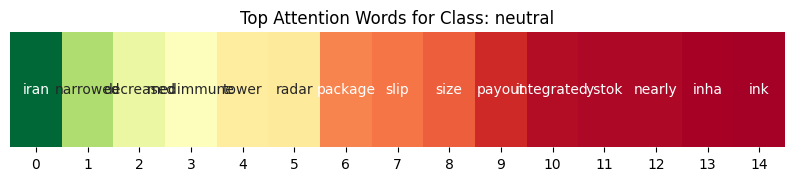

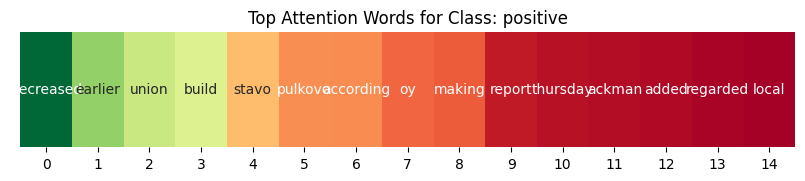

In [244]:
attn_data = collect_attention_by_class(text_test, X_test_pad, model, att_model, le, max_len, tokenizer)
top_words = compute_top_words(attn_data, le, top_n=15)
plot_attention_heatmaps(top_words)


## -WITH BIDIRECTIONAL GRU

In [258]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import tensorflow as tf

class AttentionWithContext(Layer):
    def __init__(self, return_attention=False, **kwargs):
        self.return_attention = return_attention
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='W',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.u = self.add_weight(name='u',
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionWithContext, self).build(input_shape)

    def call(self, x):
        uit = K.tanh(K.dot(x, self.W))
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.softmax(ait)

        weighted_input = x * K.expand_dims(ait)
        context_vector = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return context_vector, ait
        return context_vector

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[1])]
        else:
            return (input_shape[0], input_shape[-1])


In [313]:
def build_model_with_attention_output(max_len, vocab_size, embed_size, embedding_matrix, num_classes=3):
    inp = Input(shape=(max_len,))
    x = Embedding(input_dim=vocab_size, output_dim=embed_size,
                  weights=[embedding_matrix], input_length=max_len, trainable=False)(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(150, return_sequences=True))(x)

    x, attention_weights = AttentionWithContext(return_attention=True)(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Attention visualization model
    att_model = Model(inputs=inp, outputs=attention_weights)

    return model, att_model


In [315]:
model, att_model = build_model_with_attention_output(
    max_len=max_len,
    vocab_size=vocab_size,
    embed_size=embed_size,
    embedding_matrix=embedding_matrix,
    num_classes=3
)


In [317]:
history = model.fit(
    X_train_pad,
    y_train_ohe,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_pad, y_test_ohe)
)


Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 27s 108ms/step - accuracy: 0.5059 - loss: 1.0164 - val_accuracy: 0.6139 - val_loss: 0.8666
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 16s 106ms/step - accuracy: 0.5949 - loss: 0.8774 - val_accuracy: 0.6053 - val_loss: 0.8363
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.6221 - loss: 0.7914 - val_accuracy: 0.6644 - val_loss: 0.7850
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.6979 - loss: 0.7015 - val_accuracy: 0.6498 - val_loss: 0.7827
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.7357 - loss: 0.6030 - val_accuracy: 0.6567 - val_loss: 0.7830
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.7726 - loss: 0.5325 - val_accuracy: 0.6575 - val_loss: 0.8146
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.8033 - loss: 0.4570 - val_accuracy: 0.6327 - val_loss: 0.8150
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.8286 - loss: 0.4051 

In [318]:
loss, acc = model.evaluate(X_test_pad, y_test_ohe, verbose=0)
print(f"Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")

Test Accuracy: 0.6344, Test Loss: 1.4914


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
              precision    recall  f1-score   support

    negative       0.22      0.23      0.22       159
     neutral       0.74      0.70      0.72       666
    positive       0.65      0.69      0.67       343

    accuracy                           0.63      1168
   macro avg       0.53      0.54      0.54      1168
weighted avg       0.64      0.63      0.64      1168



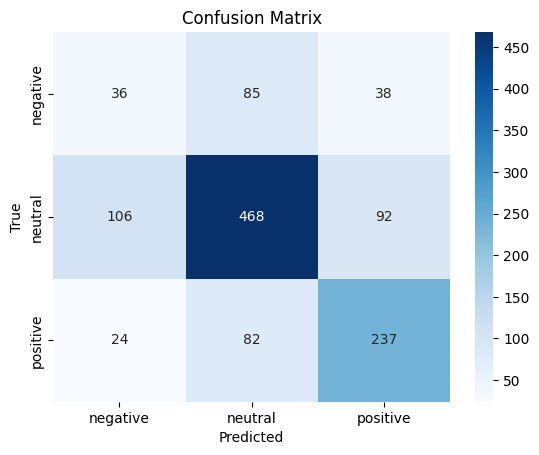

In [319]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_ohe, axis=1)

# Classification report
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [331]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tensorflow.keras.preprocessing.sequence import pad_sequences
from IPython.display import HTML

def animate_attention_over_time(text, tokenizer, att_model, max_len, interval=500):
    # Tokenize and pad
    tokens = tokenizer.texts_to_sequences([text])
    tokens_pad = pad_sequences(tokens, maxlen=max_len, padding='post')

    # Get attention weights
    att_weights = att_model.predict(tokens_pad)[0]  # (timesteps,)
    att_weights = att_weights[:np.count_nonzero(tokens_pad)]  # remove padding if needed

    words = text.split()
    words = words[:len(att_weights)]

    fig, ax = plt.subplots()
    bars = ax.bar(range(len(words)), np.zeros(len(words)), color='lightgrey')
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels(words, rotation=45)
    ax.set_ylim(0, max(att_weights) + 0.05)
    ax.set_ylabel("Attention Weight")
    ax.set_title("Animated Attention Over Time")

    def update(i):
        for j, bar in enumerate(bars):
            if j <= i:
                bar.set_height(att_weights[j])
                bar.set_color(plt.cm.RdYlGn(att_weights[j]))
            else:
                bar.set_height(0)
                bar.set_color('lightgrey')
        return bars

    ani = animation.FuncAnimation(fig, update, frames=len(words), interval=interval, repeat=False)
    plt.tight_layout()
    plt.close()  # Prevent double plot in Jupyter
    return HTML(ani.to_jshtml())


In [333]:
animate_attention_over_time(df['text'].iloc[0], tokenizer, att_model, max_len)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
